In [1]:
import pandas as pd
import os
import numpy as np
import cv2

# TP2 : IOU-based Tracking (Bounding-Box Tracker) 

In [2]:
# class for detection to help with calculations
class ObjectInstance:
    def __init__(self, frame, obj_id, bb_left, bb_top, bb_width, bb_height,):
        self.frame = int(frame)
        self.obj_id = int(obj_id)
        self.bb_left = float(bb_left)
        self.bb_top = float(bb_top)
        self.bb_width = float(bb_width)
        self.bb_height = float(bb_height)
        # self.conf = float(conf)
        # self.coord = float(x), float(y), float(z)
    
    def __repr__(self):
        return (f"ObjectInstance(frame={self.frame}, id={self.obj_id}, "
                f"bb_left={self.bb_left}, bb_top={self.bb_top}, "
                f"bb_width={self.bb_width}, bb_height={self.bb_height}, ")

# parse file and create object instances
def parse_file(file_path, separator=' '):
    objects = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(separator)[:6]
            instance = ObjectInstance(*values)
            objects.append(instance)
    return objects

# parse file with pandas
def parse_file_pd(file_path, separator=' '):
    columns = ['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z']

    df = pd.read_csv(file_path, sep=separator, header=None, names=columns)
    return df

In [3]:
# path to the data
data_path = "/home/gautier/scia2/mlvot/ADL-Rundle-6"

# sequences names
sequence_public = "public-dataset"
sequence_yolo5l = "Yolov5l"
sequence_yolo5s = "Yolov5s"

# create the path to the file
file = f"det/{sequence_yolo5l}/det.txt"
file_path = os.path.join(data_path, file)

# parse the file
parsed_objects = parse_file(file_path, ' ')
parsed_objects_pd = parse_file_pd(file_path, ' ')
parsed_objects_pd.drop(columns=['conf', 'x', 'y', 'z'], inplace=True)

# print the first 5 objects for each method
print(parsed_objects[:5])
parsed_objects_pd.head()

[ObjectInstance(frame=1, id=-1, bb_left=1700.0, bb_top=391.0, bb_width=156.0, bb_height=337.0, , ObjectInstance(frame=1, id=-1, bb_left=250.0, bb_top=456.0, bb_width=107.0, bb_height=248.0, , ObjectInstance(frame=1, id=-1, bb_left=1255.0, bb_top=539.0, bb_width=60.0, bb_height=118.0, , ObjectInstance(frame=1, id=-1, bb_left=1288.0, bb_top=459.0, bb_width=73.0, bb_height=199.0, , ObjectInstance(frame=1, id=-1, bb_left=120.0, bb_top=504.0, bb_width=93.0, bb_height=239.0, ]


,frame,id,bb_left,bb_top,bb_width,bb_height
0,1,-1,1700,391,156,337
1,1,-1,250,456,107,248
2,1,-1,1255,539,60,118
3,1,-1,1288,459,73,199
4,1,-1,120,504,93,239


In [4]:
from scipy.optimize import linear_sum_assignment

# intersection over union
def iou_jaccard(obj1 : ObjectInstance, obj2 : ObjectInstance) -> float:
    x1, y1, w1, h1 = obj1.bb_left, obj1.bb_top, obj1.bb_width, obj1.bb_height
    x2, y2, w2, h2 = obj2.bb_left, obj2.bb_top, obj2.bb_width, obj2.bb_height

    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = w1 * h1
    boxBArea = w2 * h2
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

# compute the similarity matrix
def compute_similarity_matrix(tracked : list[ObjectInstance], detected: list[ObjectInstance]) -> np.ndarray:
    n = len(tracked)
    m = len(detected)
    matrix = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            matrix[i][j] = iou_jaccard(tracked[i], detected[j])
    return matrix

# Hungarian algorithm
def hungarian_algorithm(matrix : np.ndarray) -> list:
    row_ind, col_ind = linear_sum_assignment(matrix, maximize=True)
    return zip(row_ind, col_ind)

### problem encouter

to much id : problem in my code i was not following correcly the track management algorithm

try to reduce id : increase max lost frames
but some id where reuse because sometimes because the max lost frames was to high, i found a middle ground at 20

when passing near another bounding box from an old tracked object or a current on the frame the id of one bounding box could change, i add a threshold

In [5]:
IOU_THRESHOLD = 0.1
MAX_LOST_FRAMES = 30


# manage the tracking
def track_management(detected_objects : pd.DataFrame, frame_length : int) -> pd.DataFrame:
    
    # initialize tracked objects
    tracked_objects = []
    # initialize results with pandas frame
    results = pd.DataFrame(columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'])

    idx = 1
    # iter over frames
    for frame in range(1,frame_length + 1):
        new_tracks = []

        # Get detected objects on frame
        detected_obj_on_frame = detected_objects[detected_objects['frame'] == frame]
        # no object detected on frame
        if detected_obj_on_frame.empty:
            for track in tracked_objects:
                if track.frame > frame - MAX_LOST_FRAMES:
                    new_tracks.append(track)

        # atleast one object detected on frame
        else:
            # Create ObjectInstance objects
            detected_obj_on_frame = [ObjectInstance(*obj) for obj in detected_obj_on_frame.values]

            # compute similarity matrix and matches
            similarity_matrix = compute_similarity_matrix(tracked_objects, detected_obj_on_frame)
            matches = hungarian_algorithm(similarity_matrix)

            # update tracks
            matched_detections = []
            matched_tracks = []
            for i, j in matches:
                # matched track
                if similarity_matrix[i][j] >= IOU_THRESHOLD:
                    matched_detections.append(j)
                    matched_tracks.append(i)
                    # save track 
                    old_track = tracked_objects[i]
                    # update track information
                    new_tracks.append(detected_obj_on_frame[j])
                    new_tracks[-1].obj_id = old_track.obj_id
                
                # # new track
                # else:
                #     if tracked_objects[i].frame > frame - MAX_LOST_FRAMES:
                #         new_tracks.append(tracked_objects[i])
                #     new_tracks.append(detected_obj_on_frame[j])
                #     new_tracks[-1].obj_id = idx
                #     idx += 1

            # remove old tracks
            for i in range(len(tracked_objects)):
                if i not in matched_tracks:
                    if tracked_objects[i].frame > frame - MAX_LOST_FRAMES:
                        new_tracks.append(tracked_objects[i])
            
            # add unmatched detections as new tracks
            for i in range(len(detected_obj_on_frame)):
                if i not in matched_detections:
                    new_tracks.append(detected_obj_on_frame[i])
                    new_tracks[-1].obj_id = idx
                    idx += 1


        # update results
        for track in new_tracks:
            track_df = pd.DataFrame([{'frame': track.frame, 'id': track.obj_id, 'bb_left': track.bb_left, 'bb_top': track.bb_top, 'bb_width': track.bb_width, 'bb_height': track.bb_height, 'conf': 1, 'x': -1, 'y': -1, 'z': -1}])
            results = pd.concat([results, track_df], ignore_index=True)

        # update old tracked objects with updated tracked objects
        tracked_objects = new_tracks

    # sort over frame and id
    results.sort_values(by=['frame', 'id'], inplace=True)
    return results

In [6]:
# parse seqinfo into a dictionary
def parse_seqinfo(data_path : str) -> dict:
    seq_info = {}
    with open(os.path.join(data_path, 'seqinfo.ini')) as f:
        for line in f:
            if '=' in line:
                key, value = line.strip().split('=')
                seq_info[key] = value
    return seq_info


def display_tracking_results(results : pd.DataFrame, data_path : str, output_path : str):
    # parse seqinfo
    seq_info = parse_seqinfo(data_path)

    video_path = os.path.join(data_path, 'img1')

    # Configure video reader
    frame_width = int(seq_info['imWidth'])
    frame_height = int(seq_info['imHeight'])
    frame_length = int(seq_info['seqLength'])
    # frame_length = 10
    fps = int(seq_info['frameRate'])
    
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))    

    # get results
    # results = track_management(tracked_object, frame_length)

    # draw bounding boxes
    for frame_idx in range(1, frame_length + 1):
        frame = cv2.imread(os.path.join(video_path, f'{frame_idx:06d}.jpg'))
        tracks = results[results['frame'] == frame_idx]
        for track in tracks.values:
            x, y, w, h = track[2:6]
            cv2.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            cv2.putText(frame, str(int(track[1])), (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        cv2.imshow('frame', frame)
        out.write(frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    out.release()
    cv2.destroyAllWindows()



In [7]:
results = track_management(parsed_objects_pd, int(parse_seqinfo(data_path)['seqLength']))

/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


In [15]:
results.sort_values(by=['id'], ascending=False).iloc[0]["id"]

83

In [9]:
def run_video(data_path, output_path):
    results = track_management(parsed_objects_pd, int(parse_seqinfo(data_path)['seqLength']))
    display_tracking_results(results, data_path, output_path)
    return results

output_video = "output_video/"
params_frames = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
params_threshold = [0.1, 0.2, 0.3]

history = []


for threshold in params_threshold:
    history_frame = []
    for frame in params_frames:
        IOU_THRESHOLD = threshold
        MAX_LOST_FRAMES = frame
        results = track_management(parsed_objects_pd, int(parse_seqinfo(data_path)['seqLength']))
        idmax = results.sort_values(by=['id'], ascending=False).iloc[0]["id"]
        history_frame.append(idmax)
        print(f"Threshold: {threshold}, Frame: {frame}, ID: {idmax}")
    history.append(history_frame)


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 10, ID: 109


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 20, ID: 83


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 30, ID: 70


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 40, ID: 61


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 50, ID: 57


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 60, ID: 55


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 70, ID: 48


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 80, ID: 48


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 90, ID: 47


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.1, Frame: 100, ID: 47


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 10, ID: 113


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 20, ID: 92


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 30, ID: 79


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 40, ID: 71


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 50, ID: 67


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 60, ID: 65


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 70, ID: 60


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 80, ID: 58


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 90, ID: 57


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.2, Frame: 100, ID: 56


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 10, ID: 119


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 20, ID: 100


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 30, ID: 89


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 40, ID: 82


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 50, ID: 78


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 60, ID: 77


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 70, ID: 70


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 80, ID: 68


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 90, ID: 68


/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


Threshold: 0.3, Frame: 100, ID: 67


In [10]:
gt_path = "/home/gautier/scia2/mlvot/ADL-Rundle-6/gt/gt.txt"
gt = parse_file_pd(gt_path, ',')
gt.drop(columns=['conf', 'x', 'y', 'z'], inplace=True)
id_gt = gt.sort_values(by=['id'], ascending=False).iloc[0]["id"]

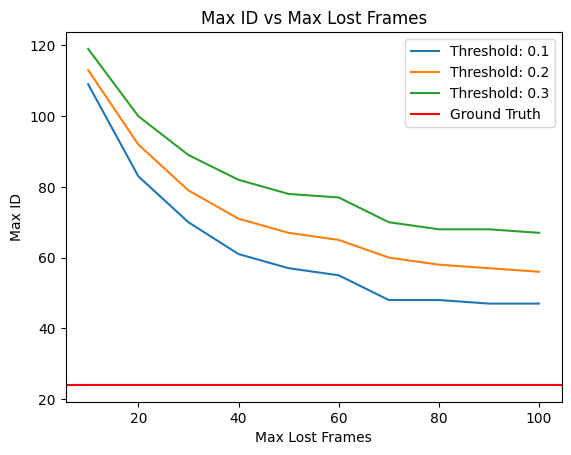

In [11]:
import matplotlib.pyplot as plt


plt.plot(params_frames, history[0], label=f"Threshold: {params_threshold[0]}")
plt.plot(params_frames, history[1], label=f"Threshold: {params_threshold[1]}")
plt.plot(params_frames, history[2], label=f"Threshold: {params_threshold[2]}")
plt.axhline(y=id_gt, color='r', linestyle='-', label="Ground Truth")
plt.xlabel('Max Lost Frames')
plt.ylabel('Max ID')
plt.title('Max ID vs Max Lost Frames')
plt.legend()
plt.show()

In [8]:
IOU_THRESHOLD = 0.1
MAX_LOST_FRAMES = 30
results = track_management(parsed_objects_pd, int(parse_seqinfo(data_path)['seqLength']))
display_tracking_results(results, data_path, "output_video/tp2_F20.mp4")
        

/tmp/ipykernel_6177/2751531811.py:74: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)


In [8]:
# Save tracking results in a txt file
def save_tracking_results(tracked_object : pd.DataFrame, output_path : str):
    tracked_object.to_csv(output_path, sep=',', index=False, header=False)


output_path = f'{sequence_yolo5l}.txt'

save_tracking_results(results, output_path)

# TP3 : Kalman-Guided IoU Tracking (Bounding-Box Tracker)

In [16]:
import numpy as np

class KalmanFilter:
    def __init__(self, dt: float, u_x: float, u_y:float, std_acc: float, x_std_meas: float, y_std_meas: float):

        self.dt = dt
        self.u = np.array([[u_x], [u_y]])
        
        self.xk = np.array([0] * 4) # State vector [x, y, vx, vy]
        self.A = np.eye(4) # State transition matrix
        self.A[0][2] = self.A[1][3] = self.dt

        self.B = np.array([[0.5 * self.dt ** 2, 0], [0, 0.5 * self.dt ** 2], [self.dt, 0], [0, self.dt]]) # Control matrix

        self.H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])

        self.Q = np.array([
            [0.25 * self.dt ** 4, 0, 0.5 * self.dt ** 3, 0], 
            [0, 0.25 * self.dt ** 4, 0, 0.5 * self.dt ** 3], 
            [0.5 * self.dt ** 3, 0, self.dt ** 2, 0], 
            [0, 0.5 * self.dt ** 3, 0, self.dt ** 2]
            ]) * std_acc ** 2
        

        self.R = np.array([
            [x_std_meas ** 2, 0],
            [0, y_std_meas ** 2]
            ]) 
        
        self.P = np.eye(4) # Covariance matrix

    def predict(self):
        # Update time state
        self.xk = self.A @ self.xk + self.B @ self.u

        # Calculate error covariance
        self.P = self.A @ self.P @ self.A.T + self.Q

    def update(self, zk: np.array):

        # Compute Kalman gain
        Sk = self.H @ self.P @ self.H.T + self.R
        Kk = self.P @ self.H.T @ np.linalg.inv(Sk)

        # Update state estimate
        a = Kk @ (zk - self.H @ self.xk)
        c = a[:, 0].reshape(-1, 1)
        self.xk = self.xk + c
        self.P = (np.eye(4) - Kk @ self.H) @ self.P

In [13]:
class Track:
    def __init__(self, frame, obj_id, bb_left, bb_top, bb_width, bb_height,):
        self.frame = int(frame)
        self.obj_id = int(obj_id)
        self.bb_left = float(bb_left)
        self.bb_top = float(bb_top)
        self.bb_width = float(bb_width)
        self.bb_height = float(bb_height)
        # self.conf = float(conf)
        # self.coord = float(x), float(y), float(z)
        self.kf = KalmanFilter(dt=0.1, u_x=1, u_y=1, std_acc=1, x_std_meas=0.1, y_std_meas=0.1)

        self.cx = self.bb_left + self.bb_width / 2
        self.cy = self.bb_top + self.bb_height / 2

        self.kf.xk = np.array([[self.cx], [self.cy], [0], [0]])

    
    def __repr__(self):
        return (f"ObjectInstance(frame={self.frame}, id={self.obj_id}, "
                f"bb_left={self.bb_left}, bb_top={self.bb_top}, "
                f"bb_width={self.bb_width}, bb_height={self.bb_height}, ")
    
    def predict(self):
        self.kf.predict()

        center = self.kf.xk[:2]

        self.bb_left = center[0] - self.bb_width / 2
        self.bb_top = center[1] - self.bb_height / 2

    def update(self, track):

        centroid = [track.cx, track.cy]
        self.kf.update(centroid)
        
        self.frame = track.frame
        self.cx = track.cx
        self.cy = track.cy

        self.bb_left = track.bb_left
        self.bb_top = track.bb_top
        self.bb_width = track.bb_width
        self.bb_height = track.bb_height

In [14]:
IOU_THRESHOLD = 0.1
MAX_LOST_FRAMES = 10

def track_management_kalman(detected_objects : pd.DataFrame, frame_length : int) -> pd.DataFrame:
    # initialize tracked objects
    tracked_objects = []
    # initialize results with pandas frame
    results = pd.DataFrame(columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'x', 'y', 'z'])
    # initalize kalman filter dictionnary
    kalman_filters = {}

    # frame_length = 10

    idx = 1
    # iter over frames
    for frame in range(1,frame_length + 1):
        # print(f"Frame {frame}/{frame_length}")
        new_tracks = []

        # Get detected objects on frame
        detected_obj_on_frame = detected_objects[detected_objects['frame'] == frame]

        
        # predict kalman filter and update tracks
        for track in tracked_objects:
            # predict kalman filter if not first appearance
            track.predict()

            # create kalman filter if first appearance
            # else:
            #     kalman_filter = create_KalmanFilter()
            #     kalman_filter.xk[:][:2][:] = track.get_centroid()
            #     print(kalman_filter.xk)
            #     kalman_filters[track.obj_id] = kalman_filter

        # no object detected on frame
        if detected_obj_on_frame.empty:
            for track in tracked_objects:
                if track.frame > frame - MAX_LOST_FRAMES:
                    new_tracks.append(track)

        # atleast one object detected on frame
        else:
            # Create ObjectInstance objects
            detected_obj_on_frame = [Track(*obj) for obj in detected_obj_on_frame.values]

            # compute similarity matrix and matches
            similarity_matrix = compute_similarity_matrix(tracked_objects, detected_obj_on_frame)
            matches = hungarian_algorithm(similarity_matrix)

            # update tracks
            matched_detections = []
            matched_tracks = []
            for i, j in matches:
                # matched track
                if similarity_matrix[i][j] >= IOU_THRESHOLD:
                    matched_detections.append(j)
                    matched_tracks.append(i)
                    # save track 
                    tracked_objects[i].update(detected_obj_on_frame[j])
                    # update track information
                    new_tracks.append(tracked_objects[i])

            # remove old tracks
            for i in range(len(tracked_objects)):
                if i not in matched_tracks:
                    if tracked_objects[i].frame > frame - MAX_LOST_FRAMES:
                        new_tracks.append(tracked_objects[i])
            
            # add unmatched detections as new tracks
            for i in range(len(detected_obj_on_frame)):
                if i not in matched_detections:
                    new_tracks.append(detected_obj_on_frame[i])
                    new_tracks[-1].obj_id = idx
                    idx += 1

        # update results
        for track in new_tracks:
            track_df = pd.DataFrame([{'frame': track.frame, 'id': track.obj_id, 'bb_left': track.bb_left, 'bb_top': track.bb_top, 'bb_width': track.bb_width, 'bb_height': track.bb_height, 'conf': 1, 'x': -1, 'y': -1, 'z': -1}])
            results = pd.concat([results, track_df], ignore_index=True)

        # update old tracked objects with updated tracked objects
        tracked_objects = new_tracks

    # sort over frame and id
    results.sort_values(by=['frame', 'id'], inplace=True)
    return results

In [17]:
results_kalman = track_management_kalman(parsed_objects_pd, int(parse_seqinfo(data_path)['seqLength']))

/tmp/ipykernel_6177/939321554.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, track_df], ignore_index=True)
/tmp/ipykernel_6177/2295919319.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  iou = interArea / float(boxAArea + boxBArea - interArea)
/tmp/ipykernel_6177/2295919319.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  matrix[i][j] = iou_jaccard(t

In [18]:
output_path = 'output_kalman.mp4'
display_tracking_results(results_kalman, data_path, output_path)

/tmp/ipykernel_6177/3391112199.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
/tmp/ipykernel_6177/3391112199.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.putText(frame, str(int(track[1])), (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)


In [19]:
output_path = f'{sequence_yolo5l}_kalman.txt'

save_tracking_results(results, output_path)